# Colab-deep-watermark

Original repo: [vinthony/deep-blind-watermark-removal/](https://github.com/vinthony/deep-blind-watermark-removal/)

Original colab: [here](https://colab.research.google.com/drive/1pYY7byBjM-7aFIWk8HcF9nK_s6pqGwww?usp=sharing)

My fork: [styler00dollar/Colab-deep-watermark](https://github.com/styler00dollar/Colab-deep-watermark)

A more userfriendly version of the official colab.

In [1]:
!nvidia-smi

Wed Jan 20 06:48:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title install
# download the necessary componments
! rm -rf *
! git clone https://github.com/vinthony/deep-blind-watermark-removal.git # get code from github
! gdown https://drive.google.com/uc?id=1KpSJ6385CHN6WlAINqB3CYrJdleQTJBc # get pretrained model
#! gdown https://drive.google.com/uc?id=18HaWfYYZCD34VttSjd2at8b9BKdhgVgU && unzip -q val.zip # get validation dataset (2.31G) of 27kpng
#! gdown https://drive.google.com/uc?id=1it5oQDRqRzBVieX6jKNmOxj1992f63yM && unzip -q natural.zip # get natural images (0.4G) of 27kpng

# rename natural images
from os import listdir
from os.path import isfile, join
import shutil
#filenames = [ shutil.copy(join('./natural', f), join('./natural', f).split('-')[0]+'.jpg') for f in listdir('./natural') if isfile(join('./natural', f)) ]

Input ```/content/image.jpg```. Run the following two cells if you change the image.

In [8]:
#@title remove folders and copy file
!sudo rm -rf /content/val_images/image/
!mkdir /content/val_images/image
!sudo rm -rf /content/val_images/mask
!mkdir /content/val_images/mask
!sudo rm -rf /content/val_images/wm
!mkdir /content/val_images/wm
!sudo rm -rf /content/natural
!mkdir /content/natural

!sudo rm -rf "/content/natural/"
!mkdir "/content/natural/"
!sudo rm -rf "/content/val_images/"
!mkdir "/content/val_images/"
!sudo rm -rf "/content/val_images/image/"
!mkdir "/content/val_images/image/"
!sudo rm -rf "/content/val_images/mask/"
!mkdir "/content/val_images/mask/"
!sudo rm -rf "/content/val_images/wm/"
!mkdir "/content/val_images/wm/"

!cp "/content/image.jpg" "/content/natural/image.jpg.jpg"
!cp "/content/image.jpg" "/content/val_images/image/image.jpg"
!cp "/content/image.jpg" "/content/val_images/mask/image.jpg"
!cp "/content/image.jpg" "/content/val_images/wm/image.jpg"

total Dataset of val_images is :  1
input          | target              | coarser            | final
----------------------------------------------------------------------------
predicted mask | predicted watermark | coarser difference | final difference


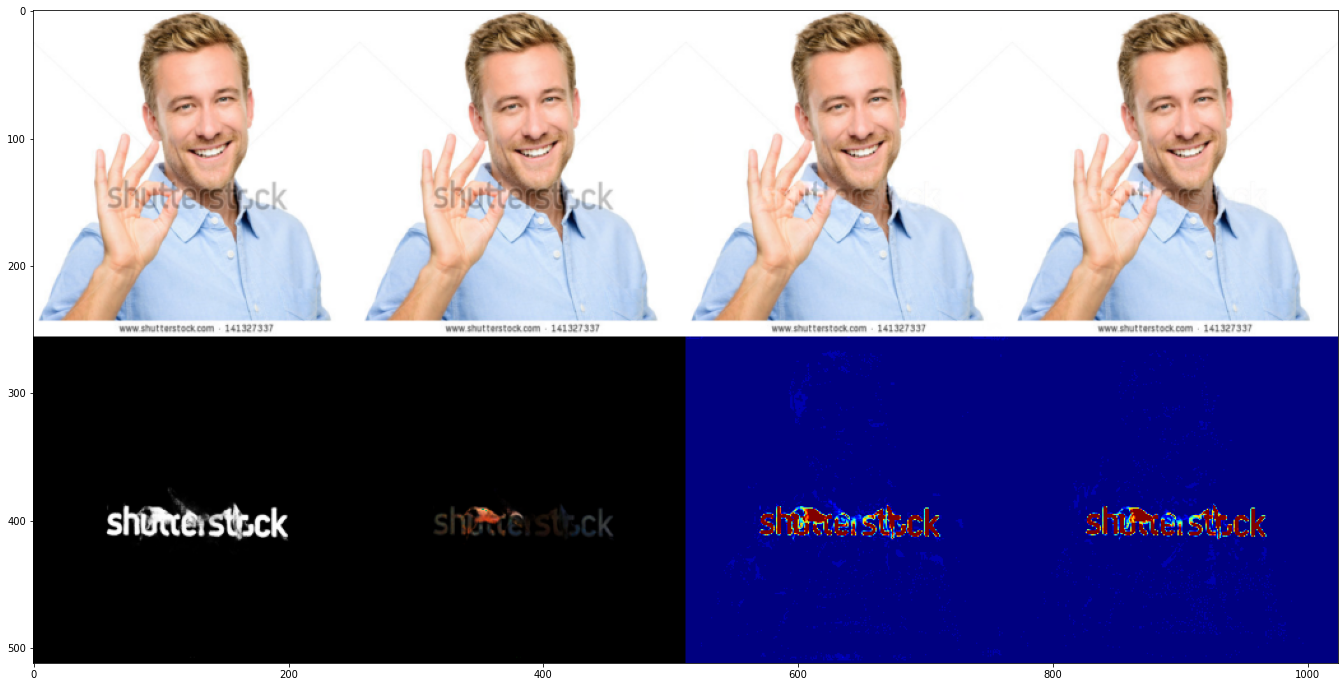

In [7]:
#@title apply
import os, sys, torch,random
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

sys.path.append('deep-blind-watermark-removal')
sys.path.insert(0,'deep-blind-watermark-removal')

from scripts.utils.imutils import im_to_numpy
import scripts.models as models
import scripts.datasets as datasets
%matplotlib inline
from PIL import Image, ImageChops

def get_jet():
    colormap_int = np.zeros((256, 3), np.uint8)
 
    for i in range(0, 256, 1):
        colormap_int[i, 0] = np.int_(np.round(cm.jet(i)[0] * 255.0))
        colormap_int[i, 1] = np.int_(np.round(cm.jet(i)[1] * 255.0))
        colormap_int[i, 2] = np.int_(np.round(cm.jet(i)[2] * 255.0))

    return colormap_int

def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

def gray2color(gray_array, color_map):
    
    rows, cols = gray_array.shape
    color_array = np.zeros((rows, cols, 3), np.uint8)
 
    for i in range(0, rows):
        for j in range(0, cols):
#             log(256,2) = 8 , log(1,2) = 0 * 8
            color_array[i, j] = color_map[clamp(int(abs(gray_array[i, j])*10),0,255)]
    
    return color_array

class objectview(object):
    def __init__(self, *args, **kwargs):
        d = dict(*args, **kwargs)
        self.__dict__ = d

jet_map = get_jet()

resume_path = '27kpng_model_best.pth.tar' # path of pretrained model
samples = [320,1364,1868] #random.sample(range(4000), 1) # show random sample 

data_config  = objectview({'input_size':256,
                            'limited_dataset':0,
                            'normalized_input':False,
                            'data_augumentation':False,
                            'base_dir':'.',
                            'data':'_images'})

val_loader = torch.utils.data.DataLoader(datasets.COCO('val',config=data_config))

print('input          | target              | coarser            | final')
print('----------------------------------------------------------------------------')
print('predicted mask | predicted watermark | coarser difference | final difference')

with torch.no_grad():

      model = models.__dict__['vvv4n']().cuda()
      model.load_state_dict(torch.load(resume_path)['state_dict'])
      model.eval()
      
      for i, batches in enumerate(val_loader):
          
          plt.figure(figsize=(48,12))

          im,mask,target = batches['image'].cuda(),batches['mask'].cuda(),batches['target'].cuda()
              
          imoutput,immask,imwatermark = model(im)
        
          imcoarser,imrefine,imwatermark = imoutput[1]*immask + im*(1-immask),imoutput[0]*immask + im*(1-immask),imwatermark*immask

          ims1 = im_to_numpy(torch.clamp(torch.cat([im,target,imcoarser,imrefine],dim=3)[0]*255,min=0.0,max=255.0)).astype(np.uint8)
          
          imcoarser, imrefine, target  = im_to_numpy((imcoarser[0]*255)).astype(np.uint8), im_to_numpy((imrefine[0]*255)).astype(np.uint8), im_to_numpy((target[0]*255)).astype(np.uint8)
          immask, imwatermark = im_to_numpy((immask.repeat(1,3,1,1)[0]*255)).astype(np.uint8),im_to_numpy((imwatermark[0]*255)).astype(np.uint8)

          coarsenp = gray2color(np.array(ImageChops.difference(Image.fromarray(imcoarser),Image.fromarray(target)).convert('L')),jet_map)
          finenp = gray2color(np.array(ImageChops.difference(Image.fromarray(imrefine),Image.fromarray(target)).convert('L')),jet_map)
          
          imfinal = np.concatenate([ims1,np.concatenate([immask,imwatermark,coarsenp,finenp],axis=1)],axis=0)

          plt.imshow(imfinal,vmin=0.0,vmax=255.0)
